In [ ]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=4b0da471540bf614bf70b1b843dfffcbab06a3dd1269473d8fa830bbb42701b1
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
import re
import string
import distance

In [4]:
df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# Removing Null Values
df.isna().sum()
df.dropna(inplace = True)

In [6]:
# Removing Duplicated Values
df.duplicated().sum()

0

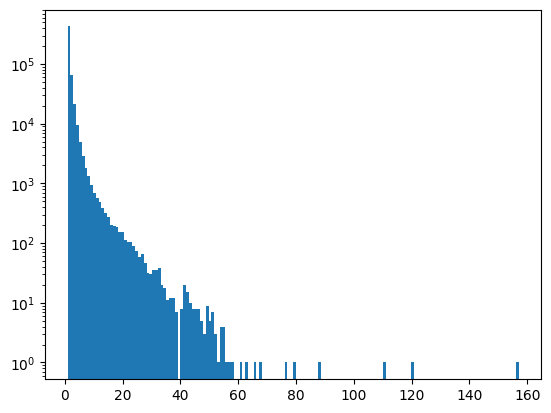

In [5]:
# Duplicate question pairs among all questions
freq_count = pd.Series(list(df['qid1']) + list(df['qid2'])).value_counts().values
plt.hist(freq_count, bins = 160)
plt.yscale('log')
plt.show()

In [8]:
new_df = df.sample(30000).loc[:, ['question1', 'question2', 'is_duplicate']]
new_questions_df = new_df[['question1', 'question2']]
new_df.head()

,question1,question2,is_duplicate
337374,What are the advantages and disadvantages of b...,What are the advantages of brain drain?,1
122571,My 11-year-old daughter is getting stares when...,I have a 10 year old daughter who refuses to g...,0
105276,How did the US arrive at 110 volts and much of...,How much maximum volts is needed to be used on...,0
70661,In what ways do people go blind?,Do most people go blind in their lifetime?,0
31790,How do women feel when they get very horny?,What should you do when you get turned down by...,0


In [10]:
all_questions = list(new_questions_df["question1"]) + list(new_questions_df["question2"])

In [11]:
cv = CountVectorizer(max_features = 3000)
vectorized = cv.fit_transform(all_questions).toarray()
vectorized.shape

(60000, 3000)

In [23]:
q1, q2 = np.vsplit(vectorized, 2)

temp_df1 = pd.DataFrame(q1, index = new_questions_df.index)
temp_df2 = pd.DataFrame(q2, index = new_questions_df.index)

temp_df = pd.concat([temp_df1, temp_df2], axis = 1)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
337374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122571,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31790,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0


In [24]:
temp_df.shape

(30000, 6000)

In [25]:
temp_df['is_duplicate'] = new_df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop(columns = ['is_duplicate']), temp_df['is_duplicate'], test_size = 0.2, random_state = 42)

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7456666666666667

---

In [7]:
new_df = df.sample(50000).loc[:, ['question1', 'question2', 'is_duplicate']]
new_questions_df = new_df[['question1', 'question2']]
new_df.head()

,question1,question2,is_duplicate
109685,Where can I find the best dog training tips?,Where can people find the best dog training tips?,1
292654,What does a kiss from a rose on a grey mean?,What does it exactly mean if a girl tackles yo...,0
59342,How widely accepted are credit cards at small ...,How widely accepted are credit cards at small ...,0
134855,How do increasing voltage decrease current in ...,How do transformers increase voltage to decrea...,1
126194,What is the typical career progression at Acce...,What is the typical career path for an NFL coach?,0


In [8]:
# All Preprocessing
def preprocessing(q: str) -> str:
    # Step 1 -: Lowercasing and removing whitespaces
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent ')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    pattern = re.compile('<.*?>')
    q = pattern.sub(r'', q)

    # Removing Punctuations
    q = q.translate(str.maketrans('', '', string.punctuation))

    # Stemming
    stemmer = PorterStemmer()
    q = ' '.join([stemmer.stem(word) for word in q.split()])

    return q

In [9]:
preprocessing('What is the step by step guide to invest in share market in india?')

'what is the step by step guid to invest in share market in india'

In [10]:
new_questions_df['question1'] = new_questions_df['question1'].apply(preprocessing)
new_questions_df['question2'] = new_questions_df['question2'].apply(preprocessing)

/tmp/ipykernel_30/4286267399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_questions_df['question1'] = new_questions_df['question1'].apply(preprocessing)
/tmp/ipykernel_30/4286267399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_questions_df['question2'] = new_questions_df['question2'].apply(preprocessing)


In [11]:
new_questions_df.head()

,question1,question2
109685,where can i find the best dog train tip,where can peopl find the best dog train tip
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach


📌 Creating Basic Features

In [12]:
# Length of question(Numbers of letters)
new_questions_df['q1_len'] = new_questions_df['question1'].str.len() 
new_questions_df['q2_len'] = new_questions_df['question2'].str.len()

In [13]:
# Number of words in all questions
new_questions_df['q1_num_words'] = new_questions_df['question1'].apply(lambda row: len(row.split(" ")))
new_questions_df['q2_num_words'] = new_questions_df['question2'].apply(lambda row: len(row.split(" ")))
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words
109685,where can i find the best dog train tip,where can peopl find the best dog train tip,39,43,9,9
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...,42,87,11,20
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...,68,82,13,16
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...,56,50,10,8
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach,45,46,8,10


In [14]:
# number of common words in both the question
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

new_questions_df['word_common'] = new_questions_df.apply(common_words, axis=1)
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common
109685,where can i find the best dog train tip,where can peopl find the best dog train tip,39,43,9,9,8
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...,42,87,11,20,6
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...,68,82,13,16,12
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...,56,50,10,8,6
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach,45,46,8,10,5


In [15]:
# Total unique words in both q1 and q2
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

new_questions_df['word_total'] = new_questions_df.apply(total_words, axis=1)
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
109685,where can i find the best dog train tip,where can peopl find the best dog train tip,39,43,9,9,8,18
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...,42,87,11,20,6,27
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...,68,82,13,16,12,28
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...,56,50,10,8,6,18
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach,45,46,8,10,5,18


In [16]:
# percent word sharing by both the questions
new_questions_df['word_share'] = round(new_questions_df['word_common']/new_questions_df['word_total'],2)
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
109685,where can i find the best dog train tip,where can peopl find the best dog train tip,39,43,9,9,8,18,0.44
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...,42,87,11,20,6,27,0.22
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...,68,82,13,16,12,28,0.43
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...,56,50,10,8,6,18,0.33
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach,45,46,8,10,5,18,0.28


📌 Creating Advance Features

In [17]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [18]:
token_features = new_questions_df.apply(fetch_token_features, axis=1)

new_questions_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_questions_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_questions_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_questions_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_questions_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_questions_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_questions_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_questions_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [19]:
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
109685,where can i find the best dog train tip,where can peopl find the best dog train tip,39,43,9,9,8,18,0.44,0.999980,0.833319,0.999967,0.749981,0.888879,0.888879,1.0,1.0
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...,42,87,11,20,6,27,0.22,0.599988,0.333330,0.749981,0.333330,0.545450,0.299999,0.0,1.0
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...,68,82,13,16,12,28,0.43,0.874989,0.699993,0.999980,0.999980,0.923070,0.749995,0.0,1.0
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...,56,50,10,8,6,18,0.33,0.799984,0.571420,0.666644,0.666644,0.749991,0.599994,0.0,1.0
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach,45,46,8,10,5,18,0.28,0.499988,0.399992,0.749981,0.599988,0.624992,0.499995,0.0,1.0


In [24]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if(len(strs) != 0):
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0 / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [25]:
length_features = new_questions_df.apply(fetch_length_features, axis=1)

new_questions_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_questions_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_questions_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [26]:
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
109685,where can i find the best dog train tip,where can peopl find the best dog train tip,39,43,9,9,8,18,0.44,0.999980,0.833319,0.999967,0.749981,0.888879,0.888879,1.0,1.0,0.0,9.0,0.700000
292654,what doe a kiss from a rose on a grey mean,what doe it exactli mean if a girl tackl you t...,42,87,11,20,6,27,0.22,0.599988,0.333330,0.749981,0.333330,0.545450,0.299999,0.0,1.0,9.0,15.5,0.209302
59342,how wide accept are credit card at small busi ...,how wide accept are credit card at small busi ...,68,82,13,16,12,28,0.43,0.874989,0.699993,0.999980,0.999980,0.923070,0.749995,0.0,1.0,3.0,14.5,0.884058
134855,how do increas voltag decreas current in ac po...,how do transform increas voltag to decreas cur...,56,50,10,8,6,18,0.33,0.799984,0.571420,0.666644,0.666644,0.749991,0.599994,0.0,1.0,2.0,9.0,0.313725
126194,what is the typic career progress at accentur,what is the typic career path for an nfl coach,45,46,8,10,5,18,0.28,0.499988,0.399992,0.749981,0.599988,0.624992,0.499995,0.0,1.0,2.0,9.0,0.565217
